# Protecting against Reidentification Attacks with Differential Privacy

In this notebook we show how differential privacy can be used to protect sensitive personal information against re-identification attacks. The identities of individuals might be revealed if an attacker is able to map anonymized records about individuals from a published dataset with information about these people from various sources. 
In this demo, the published anonymized dataset contains patient records. The attacker tries to identify individuals by leveraging basic demographic information like age and zip codes.
We show that successful reidentification attacks are possible even when the sensitive data is published in an anonymized format. Then, we perform a second attack after protecting the sensitive data using a dataset synthesizer from the SmartNoise system.


This demo is based on the following steps:
1. Import of anonymized medical data set and the attacker's data collection
2. Reidentification Attack I: Revealing identities from the anonymized data set 
3. Protecting the medical dataset with differential privacy using Multiple Weights Exponential Mechanism (MWEM)
4. Validating the utility of the synthesized data set for statistical analyses
5. Reidentification Attack II: Trying to reveal identities based on the differentially private version of the medical data set

In [1]:
# Install required libraries, uncomment if needed
# %pip install git+https://github.com/opendifferentialprivacy/smartnoise-sdk#subdirectory=sdk
# %pip install faker zipcodes tqdm opendp-smartnoise
!pip install z3-solver==4.8.9.0

You should consider upgrading via the 'd:\repos\opendp-smartnoise-samples\.venv\scripts\python.exe -m pip install --upgrade pip' command.


In [11]:
import warnings
warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import pandas as pd
import numpy as np
import random
import string
import uuid
import time
import logging
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import reident_tools as reident
from opendp.smartnoise.synthesizers.mwem import MWEMSynthesizer

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

## Import data sets
Below, we are going to import three data sets:
1. Public medical data set, containing k-anonymized demographic and sensitive medical information
2. Attacker's data collection with basic demographic information
3. Public medical data set preprocessed for the MWEM synthesizer

In [12]:
# Read files
df_medical = pd.read_csv('data/data_medical.csv', sep=",", encoding="utf-8").infer_objects()
df_medical['Zip'] = df_medical['Zip'].astype(str)
print('Anonymized dataset including sensitive medical information:')
display(df_medical.iloc[:,1:].sample(8))
df_demographic = pd.read_csv('data/data_demographic.csv', sep=",", encoding="utf-8").infer_objects()
print('Attacker`s data collection with basic demographic information:')
df_demographic['Zip'] = df_demographic['Zip'].astype(str)
display(df_demographic.iloc[:,1:].sample(8))
df_medical_synth = pd.read_csv('data/data_medical_synthesizer.csv', sep=",", encoding="utf-8").infer_objects()
df_medical_synth['Zip'] = df_medical_synth['Zip'].astype(str)

Anonymized dataset including sensitive medical information:


,Gender,Age,Zip,Diagnosis,Treatment,Outcome
20136,F,70-79,700**,Osteoporosis,26,recovered
10498,F,40-49,888**,Cancer,28,recovered
10915,M,60-69,862**,Osteoporosis,20,intensive care
2622,M,20-29,888**,COPD,46,recovered
16521,M,30-39,824**,Osteoporosis,24,unchanged
240,F,20-29,660**,High Blood Pressure,27,intensive care
5321,F,80-89,165**,Osteoporosis,28,recovered
28545,M,80-89,110**,High Blood Pressure,42,intensive care


Attacker`s data collection with basic demographic information:


,Name,Gender,Age,Zip
19894,Kelli Li,F,61,81294
12317,Robert Walker,M,20,96753
27357,Christine Martinez,F,80,77331
1235,Jill Wright,F,78,49974
12343,Gary Joseph,M,25,60531
16709,John Webb,M,50,70314
24723,Kristen Blake DVM,F,85,65063
11360,William Mccall,M,52,23915


Above data sets also include a unique id for each record which is used to be able to count the number of identified records after the attack. This information is not used for performing the attack. 

## Reidentification Attack I - Revealing identities from the anonymized data set
Below, we perform the first reidentification attack usind the `try_reidentification` function. As input, we use the data sets generated above (published medical and demographic data).

### Perform the attack
Now, we perform the reidentification attack with the demographic and the medical data set, using a combinatorial approach.

In [13]:
%%time
reident_attack = reident.try_reidentification(df_demographic, df_medical, logger)

INFO:root:Performing reidentification with anonymized data: 30000. Attacker collection: 30000
100%|██████████| 30000/30000 [04:38<00:00, 107.74it/s]
INFO:root:Identified 28962 potential matches!
INFO:root:Validating IDs ...
100%|██████████| 28962/28962 [00:00<00:00, 32539.02it/s]
INFO:root:Identified 9069 actual (validated) matches!


Wall time: 4min 39s


### Results of the attack
Below, we show the amount of potential and actual matches and provide a glance at the data.

In [14]:
print(f'Found: {len(reident_attack[reident_attack["ID_Match"]==True])} actual (validated) matches!')

Found: 9069 actual (validated) matches!


In [6]:
# Write to file, if wanted
# reident_attack.to_csv('data/results_reident-attack-raw.csv', sep=",", encoding="utf-8", index=False)
# Or read files, if needed
# reident_attack = pd.read_csv('data/results_reident-attack-raw.csv', sep=",", encoding="utf-8")

In [15]:
# Get sample from the data set
print(f'Sample of re-identified patients:')
reident_attack[reident_attack["ID_Match"]==True][['Name', 'Gender', 'Age', 'Zip', 'Diagnosis', 'Treatment', 'Outcome', 'ID_Match']].sample(10)

Sample of re-identified patients:


,Name,Gender,Age,Zip,Diagnosis,Treatment,Outcome,ID_Match
17350,Elizabeth Olson MD,F,76,23288,Alzheimer,35,unchanged,True
25378,Kelly Sullivan,F,67,81990,Heart Disease,38,recovered,True
12580,Lauren Graham,F,68,71815,Heart Disease,47,recovered,True
6797,Mario Davis,M,47,36458,Diabetes,35,unchanged,True
22340,Melissa Kelley,F,39,31550,High Blood Pressure,41,recovered,True
29380,Karen Brown,F,21,82891,Diabetes,34,unchanged,True
9880,Bridget Knapp,F,45,17335,Heart Disease,41,recovered,True
15632,Katelyn Carlson,F,81,29142,High Blood Pressure,44,unchanged,True
22165,Andrew Anderson,M,28,44236,High Blood Pressure,43,recovered,True
21189,Maureen Mayer,F,11,87949,COPD,43,unchanged,True


## Protecting the medical dataset with differential privacy
In the next step, we are going to synthesize the data set to increase the level of protection. We will use the Multiple Weights Exponential Mechanism (MWEM) synthesizer for this purpose and encode the demographic data (gender, age, zip) and the diagnosis. The other variables (treatment, outcome) are not part of the analysis for now.

In [16]:
# Prepare data set for reidentification, using the medical data set and the full zip copied from the demographic set
df_reident_synth = df_medical[['Gender', 'Age', 'Zip', 'Diagnosis', 'Treatment', 'Outcome']].copy()
df_reident_synth['Zip'] = df_demographic['Zip'].copy()
df_reident_synth['Age'] = df_demographic['Age'].copy()
# Write to file, if wanted
# df_reident_synth.to_csv('data/data_reidentification_synthesizer.csv', sep=",", encoding="utf-8", index=False)

### Encoding of data
For this purpose, we encode the input data using the `do_encode`-function to make it compatible with the MWEM synthesizer.

In [17]:
# Have a quick glance at the data
df_reident_synth.head()

,Gender,Age,Zip,Diagnosis,Treatment,Outcome
0,F,10,65418,High Blood Pressure,25,intensive care
1,F,14,65475,COPD,48,unchanged
2,F,10,65484,High Blood Pressure,38,intensive care
3,F,30,27727,Heart Disease,31,unchanged
4,F,36,27772,Diabetes,34,unchanged


In [18]:
# Encode the data set and display it
df_reident_encoded = reident.do_encode(df_reident_synth, ['Gender', 'Age', 'Zip', 'Diagnosis'], reident.diseases)
df_reident_encoded.head()

,Gender_encoded,Age_encoded,Zip_encoded,Diagnosis_encoded
0,0,10,65418,9
1,0,14,65475,2
2,0,10,65484,9
3,0,30,27727,7
4,0,36,27772,3


### Synthesizing the demographic data
Finally, we synthesize the data with the MWEM synthesizer. Here are some considerations regarding the parameters:
- `Q_count` Should be higher than the number of iterations (at least 5 and 10 times the number of iterations). Default is 400.
- `epsilon`The privacy parameter. 3.0 is a good starting points. Lower values correspond to a higher levels of privacy.
- `iterations` Comparable to epochs in deep learning. Between 30 and 60. Fewer iterations means that the budget is used more efficiently. Default is 30.
- `mult_weights_iterations` Should be less than number of total iterations (usually between 5 and 50). Default is 20.
- `splits` MWEM will automatically split the features with split factor if this field isn’t specified. This field overrides split_factor, and creates custom user specified splits of features i.e. for a set with 5 features, [[0,3],[1,2,4]] (implies that features 0 and 3 are correlated, and features 1,2 and 4 are correlated).
- `split_factor` Choose highest split factor without affecting performance. Start with number of features, then subdivide by 2 (round up).

In [19]:
%%time
# Apply the synthesizer to the data set
synthetic_data = MWEMSynthesizer(q_count = 400,
                        epsilon = 3.00,
                        iterations = 60,
                        mult_weights_iterations = 40,
                        splits = [],
                        split_factor = 1)
synthetic_data.fit(df_reident_encoded.to_numpy())

Wall time: 5.99 s


In [20]:
%%time
# Convert to dataframe
df_synthesized = pd.DataFrame(synthetic_data.sample(int(df_reident_encoded.shape[0])), columns=df_reident_encoded.columns)

Wall time: 2.34 s


In [13]:
# Write it to file, if wanted
# df_synthesized.to_csv('data/data_synthesized.csv', sep=",", encoding="utf-8", index=False)

### Compare original and synthetic data
Below, we are going to use the `create_histogram` function to illustrate the __diagnoses__ distribution of both data sets. 
Ideally, the bars for each diagnosis do not differ too much from each other. The more similar the bars are for the respective disease, the less information is lost during the synthetization process.

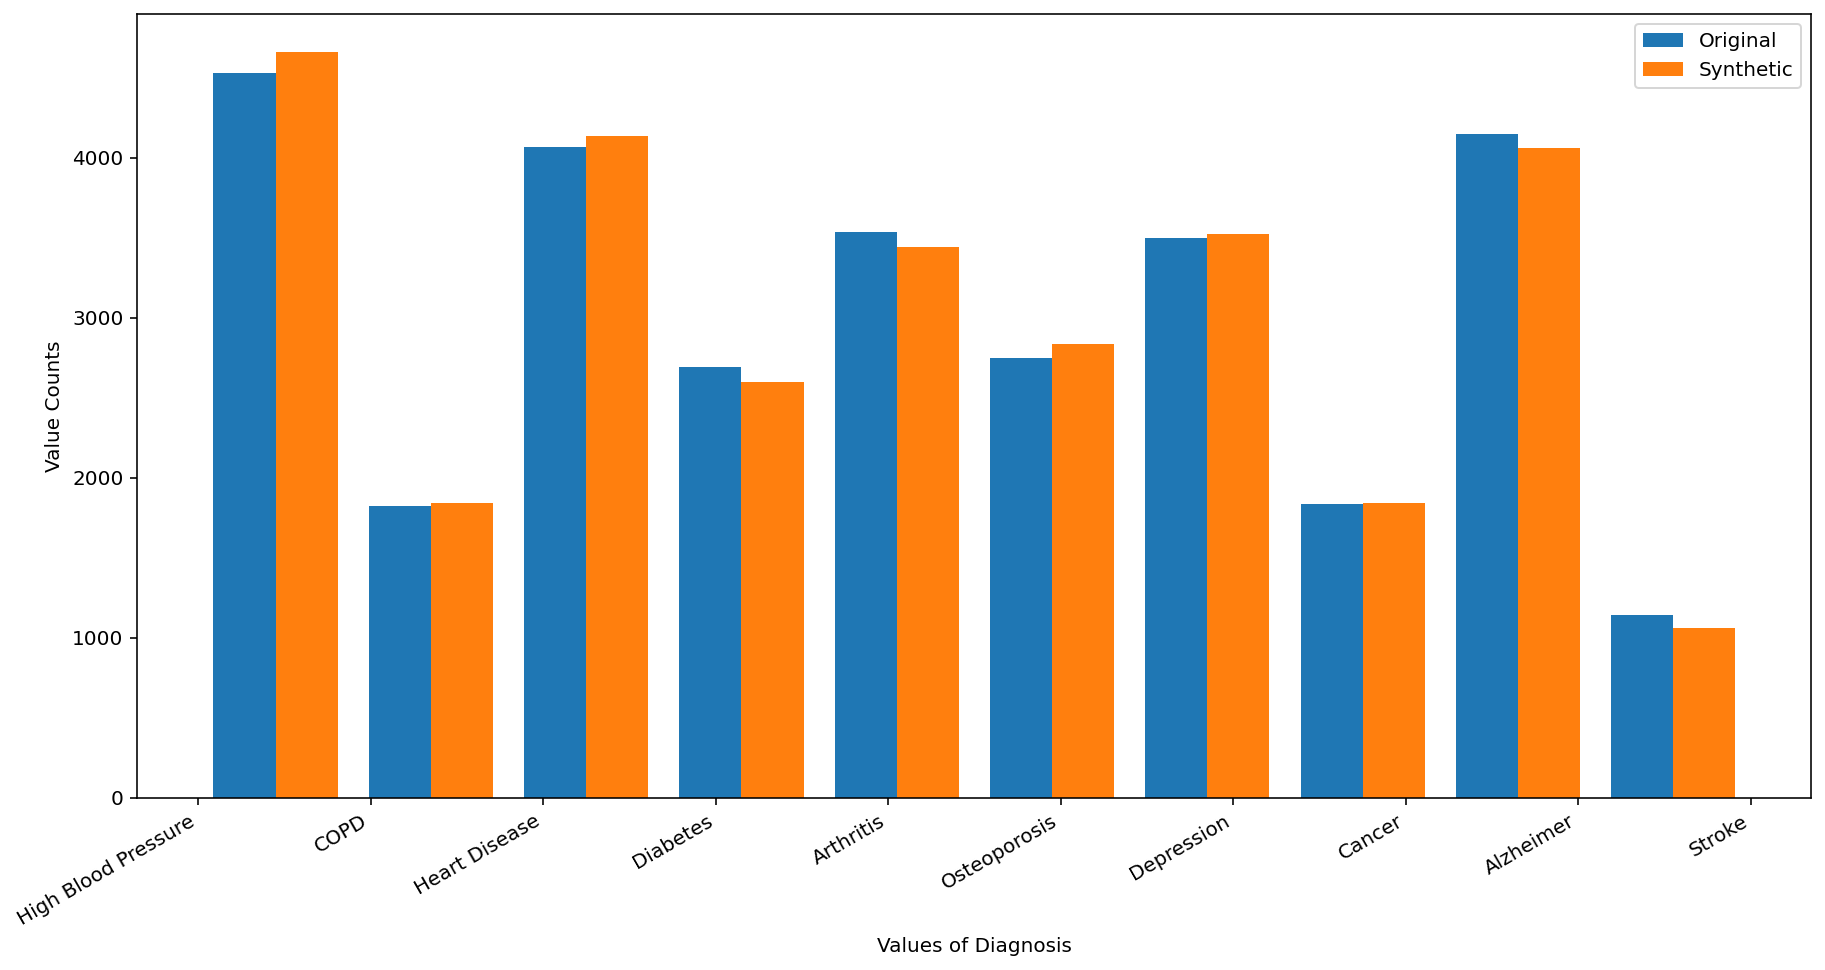

In [21]:
reident.create_histogram(df_reident_encoded, df_synthesized, 'Diagnosis_encoded', reident.diseases)

## Reidentification Attack II - Synthesized Demographic Data + Public Medical Data (non-grouped)
Finally, we try the re-identification attack on the synthesized data using the `try_reidentification_noise`-function.
As stated above, the synthesized data set has new combinations of demographic data, so we do not deal with the _raw/real_ data any more. While it is possible that a potential match is detected, it is unlikely that we deal with an actual match here.

In [22]:
print('Medical Dataset:')
display(df_medical_synth.sample(5))
print('\nSynthesized Demographic Dataset:')
display(df_synthesized.sample(5))

Medical Dataset:


,ID,Gender,Age,Zip,Diagnosis,Treatment,Outcome
7017,3faa34259c584f6097a66faa38e88a06,M,48,33615,COPD,37,recovered
12240,4b6a1956aa174890a8fde2afd887b926,M,52,60581,Alzheimer,42,intensive care
5644,5a65424729cf450eb954d4b3c7323a8c,M,36,23840,Arthritis,42,unchanged
4604,6ea2e53ac5d34c22b086cdc0874c0833,F,30,26665,High Blood Pressure,22,unchanged
16367,1fdf784cb8d94b43aec176338d84bc89,F,61,63616,Alzheimer,31,unchanged



Synthesized Demographic Dataset:


,Gender_encoded,Age_encoded,Zip_encoded,Diagnosis_encoded
18938,1,69,7673,7
9274,0,17,61993,8
15549,1,31,54432,6
29353,0,68,14239,0
22411,0,60,4091,2


### Perform the attack
Now, we perform the reidentification attack with the synthetic data, again using a combinatorial approach.

In [23]:
reident_attack_2 = reident.try_reidentification_noise(df_synthesized, df_medical_synth, logger)

INFO:root:Trying reidentification with differential privacy-protected data: 30000. Attacker collection: 30000
INFO:root:In this setup, we can only count potential matches. We cannot validate for actual matches, as we do not have the unique patient ids after synthesizing.
 14%|█▍        | 4325/30000 [00:12<01:16, 336.87it/s]


KeyboardInterrupt: 

### Results of the attack
Below, we show the amount of potential and actual matches and provide a glance at the data.

In [17]:
print(f'Found {len(reident_attack_2)} potential matches!')
reident_attack_2.head()

Found 0 potential matches!


,ID,Gender,Age,Zip,Diagnosis,Treatment,Outcome
